# 3. AE for reconstruction

**Outline is as follows:**
- Build model and loss function
- Train, validate, test

**To do:**
- Hyperparameter tuning
    + learning rate
    + layer1, layer2
    + beta1, beta2
    
**Modification**
- Weight initialization with xavier uniform
- Adam optimization
- LR decay

In [1]:
import importlib
import argparse
import os, sys
import argparse
import pandas as pd
import numpy as np
import pickle
import time

In [2]:
import torch
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler
from torch.autograd import Variable
from torchvision import transforms

In [3]:
sys.path.insert(0, './utils/')
from utils import *
from models import *

In [4]:
#Define parser
name = 'small_log'


parser = {
    'train': True,
    'test': True,
    'model_class': 'AE',
    'model_name': '',
    'data_dir': './',
    'data_file': name + '.csv',
    'nan_pct': 0.3,
    'input_dir': './',
    'batch_size' : 2,
    'epochs' : 50,
    'no_cuda' : False,
    'seed' : 7,
    'layer1': 300,
    'layer2': 100,
    'lr': 0.0005,
    'betas': (0.9, 0.999),
    'lr_decay': 0.90,
}

args = argparse.Namespace(**parser)
args.output_dir = './output/{0}_{1}_{2}/'.format(name, args.nan_pct, args.model_class)

In [5]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

In [6]:
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [7]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [8]:
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

In [9]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_full_{}.pkl'.format(args.nan_pct))

with open(preprocessed_data_name, 'rb') as f:
    min_max_storage = pickle.load(f)
    complete_matrix_w_normalized_time = pickle.load(f)
    missing_matrix_w_normalized_time = pickle.load(f)
    avai_matrix = pickle.load(f)
    nan_matrix = pickle.load(f)
    pad_matrix = pickle.load(f)
    cols_w_time = pickle.load(f)
    cols_w_normalized_time = pickle.load(f)

In [10]:
file_name = os.path.join(args.input_dir, 'parameters_{}.pkl'.format(args.nan_pct))

with open(file_name, 'rb') as f:
    most_frequent_activity = pickle.load(f)
    first_timestamp = pickle.load(f)

    avai_instance = pickle.load(f)
    nan_instance = pickle.load(f)

    train_size = pickle.load(f)
    val_size = pickle.load(f)
    test_size = pickle.load(f)

    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)

## Loading data

In [11]:
complete_matrix_w_normalized_time_trainLoader = torch.utils.data.DataLoader(complete_matrix_w_normalized_time,
                                                                            batch_size=args.batch_size, shuffle=False,
                                                                            num_workers=2)
missing_matrix_w_normalized_time_trainLoader = torch.utils.data.DataLoader(missing_matrix_w_normalized_time,
                                                                           batch_size=args.batch_size, shuffle=False,
                                                                           num_workers=2)
avai_matrix_trainLoader = torch.utils.data.DataLoader(avai_matrix,
                                                      batch_size=args.batch_size, shuffle=False,
                                                      num_workers=2)

In [12]:
normalized_complete_df_name = os.path.join(args.input_dir, 'normalized_complete_df_{}.csv'.format(args.nan_pct))
normalized_complete_df = pd.read_csv(normalized_complete_df_name)

normalized_missing_df_name = os.path.join(args.input_dir, 'normalized_missing_df_{}.csv'.format(args.nan_pct))
normalized_missing_df = pd.read_csv(normalized_missing_df_name)

In [13]:
missing_true_test = normalized_missing_df
complete_true_test = normalized_complete_df

In [14]:
nan_time_index, nan_activity_index = getnanindex(missing_true_test)

In [15]:
row_num = missing_true_test.shape[0]
row_num

28000

In [16]:
complete_matrix_w_normalized_time.shape

(2000, 14, 15)

## Building the model

### Define model

In [17]:
if args.model_class == 'AE':
    model = AE(complete_matrix_w_normalized_time.shape, args.layer1, args.layer2)

if args.cuda:
    model.cuda()

/content/./utils/models.py:28: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2))
/content/./utils/models.py:29: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc2.weight, gain=np.sqrt(2))


### Define loss

In [18]:
# Define loss

def loss_function(recon_x, x, avai_mask):
    #MSE = F.mse_loss(recon_x*avai_mask, x*avai_mask, size_average=False)
    BCE = F.binary_cross_entropy(recon_x, x, weight=avai_mask, size_average=False)
    return BCE

In [19]:
optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=args.betas)

In [20]:
#Adjust learning rate per epoch:

lambda1 = lambda epoch: args.lr_decay ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])


## Utility fucntions

In [21]:
def save_model(model, epoch, score):
    model_file = os.path.join(args.output_dir, 'model_{}_epoch{}_score{:.4f}.pth'.format(args.model_class, epoch, score))
    torch.save(model.state_dict(), model_file)

In [22]:
def load_model(model, model_name):
    model_file = os.path.join(args.output_dir, model_name)
    assert os.path.isfile(model_file), 'Error: no model found!'
    model_state = torch.load(model_file)
    model.load_state_dict(model_state)

## Training the model

In [23]:
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (m_data, c_data, avai_mask) in enumerate(zip(missing_matrix_w_normalized_time_trainLoader,
                                                                complete_matrix_w_normalized_time_trainLoader,
                                                                avai_matrix_trainLoader)):
        c_data = Variable(c_data.float())
        m_data = Variable(m_data.float())
        avai_mask = Variable(avai_mask.float())

        if args.cuda:
            c_data = c_data.cuda()
            m_data = m_data.cuda()
            avai_mask = avai_mask.cuda()


        optimizer.zero_grad()

        recon_data = model(m_data)

        loss = loss_function(recon_data, c_data, avai_mask)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    return train_loss / len(complete_matrix_w_normalized_time_trainLoader.dataset)

In [24]:
if args.train:
    for epoch in range(1, args.epochs + 1):
        init = time.time()

        #method 1 scheduler
        scheduler.step()
        train_loss = train(epoch, model, optimizer)

        end = time.time()
        print('====> Epoch {} | End time: {:.4f} ms | Train loss: {:.4f}'.
              format(epoch, (end-init)*1000, train_loss))
else:
    load_model(model, args.model_name)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Epoch 1 | End time: 22882.1537 ms | Train loss: 11.7908
====> Epoch 2 | End time: 28679.6563 ms | Train loss: 5.1268
====> Epoch 3 | End time: 12365.7978 ms | Train loss: 4.8785
====> Epoch 4 | End time: 9766.6259 ms | Train loss: 4.8436
====> Epoch 5 | End time: 10416.3802 ms | Train loss: 4.8323
====> Epoch 6 | End time: 11456.2271 ms | Train loss: 4.8274
====> Epoch 7 | End time: 10156.9495 ms | Train loss: 4.8247
====> Epoch 8 | End time: 11785.6154 ms | Train loss: 4.8231
====> Epoch 9 | End time: 11204.1972 ms | Train loss: 4.8221
====> Epoch 10 | End time: 10053.0684 ms | Train loss: 4.8214
====> Epoch 11 | End time: 13285.7554 ms | Train loss: 4.8209
====> Epoch 12 | End time: 11628.0992 ms | Train loss: 4.8205
====> Epoch 13 | End time: 10962.0583 ms | Train loss: 4.8203
====> Epoch 14 | End time: 9971.1719 ms | Train loss: 4.8201
====> Epoch 15 | End time: 11163.6596 ms | Train loss: 4.8199
====> Epoch 16 | End time: 12155.6759 ms | Train loss: 4.8198
====> Epoch 17 | E

## Predict and evaluate

In [25]:
pad_matrix.shape

(2000, 14, 15)

In [26]:
missing_matrix_w_normalized_time.shape

(2000, 14, 15)

In [27]:
from utils import *

In [28]:
import pandas as pd
import numpy as np
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, log_loss
import torch
import torch.nn as nn
from datetime import timedelta

'''
Note: 2 way to index an element in pandas df
By Index:
- df.Time[row]
- df.loc[row, 'Time']

By location:
- df.iloc[1, 1]: iloc only takes integer

'''
def calculateTimeInterval(missing_data):
    df = missing_data.copy()
    df['TimeInterval'] = (df['CompleteTimestamp'] - df['CompleteTimestamp'].shift(1))
    df.loc[0, 'TimeInterval'] = pd.Timedelta(seconds=0)
    return df

def calculateDuration(missing_data):
    df = missing_data.copy()
    df['Duration'] = (df['CompleteTimestamp'] - df['CompleteTimestamp'].iloc[0])
    df['Duration'].iloc[0] = 0
    return df

def calculateCumTimeInterval(missing_data):
    df = missing_data.copy()
    df['CumTimeInterval'] = (df['CompleteTimestamp'] - df['CompleteTimestamp'].iloc[0])
    return df

def calculateCaseTimeInterval(missing_data):
    df = missing_data.copy()
    df['CaseTimeInterval'] = np.nan

    current_point = {}
    current_point[df.loc[0, 'CaseID']] = df.loc[0, 'CompleteTimestamp']

    for i in range(1, df.shape[0]):
        if df.loc[i, 'CaseID'] != df.loc[i-1, 'CaseID']:
            df.loc[i, 'CaseTimeInterval'] = (df.loc[i, 'CompleteTimestamp'] - current_point[df.loc[i, 'CaseID']-1]).total_seconds()
            current_point[df.loc[i, 'CaseID']] = df.loc[i, 'CompleteTimestamp']

    return df

def convert2seconds(x):
    x = x.total_seconds()
    return x


def minmaxScaler(caseid, df_case, missing_df_case):
    epsilon = 0.1
    missing_case_storage = {}
    missing_case_storage[caseid] = {}

    temp = df_case.copy()
    missing_temp = missing_df_case.copy()

    temp['NormalizedTime'] = temp['CumTimeInterval'].copy()
    missing_temp['NormalizedTime'] = missing_temp['CumTimeInterval'].copy()

    min_val = temp['CumTimeInterval'].min()
    max_val = temp['CumTimeInterval'].max()

    missing_min_val = missing_temp['CumTimeInterval'].min()
    missing_max_val = missing_temp['CumTimeInterval'].max()
    missing_case_storage[caseid]['missing_min_val'] = missing_min_val
    missing_case_storage[caseid]['missing_max_val'] = missing_max_val

    for row in range(temp.shape[0]):
        #scale complete df
        temp.iloc[row, temp.columns.get_loc('NormalizedTime')] = (temp.iloc[row, temp.columns.get_loc('CumTimeInterval')] - min_val)/(max_val-min_val+epsilon)

        #scale missing df
        missing_temp.iloc[row, missing_temp.columns.get_loc('NormalizedTime')] = (missing_temp.iloc[row, missing_temp.columns.get_loc('CumTimeInterval')] - missing_min_val)/(missing_max_val-missing_min_val+epsilon)
    return temp, missing_temp, missing_case_storage


def OHE(df, categorical_variables):
    for i in categorical_variables:
        enc_df = pd.get_dummies(df, columns=categorical_variables, drop_first=False)
    return enc_df

def findLongestLength(groupByCase):
    '''This function returns the length of longest case'''
    #groupByCase = data.groupby(['CaseID'])
    maxlen = 1
    for case, group in groupByCase:
        temp_len = group.shape[0]
        if temp_len > maxlen:
            maxlen = temp_len
    return maxlen

def padwithzeros(vector, maxlen):
    '''This function returns the (maxlen, num_features) vector padded with zeros'''
    npad = ((maxlen-vector.shape[0], 0), (0, 0))
    padded_vector = np.pad(vector, pad_width=npad, mode='constant', constant_values=0)
    return padded_vector

# def getInput(groupByCase, cols, maxlen):
#     full_list = []
#     for case, data in groupByCase:
#         temp = data.as_matrix(columns=cols)
#         temp = padwithzeros(temp, maxlen)
#         full_list.append(temp)
#     inp = np.array(full_list)
#     return inp

def getMeanVar(array, idx=0):
    temp_array = [a[idx] for a in array if not np.isnan(a[idx])]
    mean_val = np.mean(temp_array)
    var_val = np.var(temp_array)
    return mean_val, var_val

def getProbability(recon_test):
    '''This function takes 3d tensor as input and return a 3d tensor which has
    probabilities for classes of categorical variable'''
    softmax = nn.Softmax()
    #recon_test = recon_test.cpu() #moving data from gpu to cpu for full evaluation

    for i in range(recon_test.size(0)):
        cont_values = recon_test[i, :, 0].contiguous().view(recon_test.size(1),1) #(35,1)
        softmax_values = softmax(recon_test[i, :, 1:])
        if i == 0:
            recon = torch.cat([cont_values, softmax_values], 1)
            recon = recon.contiguous().view(1,recon_test.size(1), recon_test.size(2)) #(1, 35, 8)
        else:
            current_recon = torch.cat([cont_values, softmax_values], 1)
            current_recon = current_recon.contiguous().view(1,recon_test.size(1), recon_test.size(2)) #(1, 35, 8)
            recon = torch.cat([recon, current_recon], 0)
    return recon

def convert2df(predicted_tensor, pad_matrix, cols, test_row_num):
    '''
    This function converts a tensor to a pandas dataframe
    Return: Dataframe with columns (NormalizedTime, PredictedActivity)

    - predicted_tensor: recon
    - df: recon_df_w_normalized_time
    '''
    predicted_tensor = getProbability(predicted_tensor) #get probability for categorical variables
    predicted_array = predicted_tensor.data.cpu().numpy() #convert to numpy array

    #Remove 0-padding
    temp_array = predicted_array*pad_matrix
    temp_array = temp_array.reshape(predicted_array.shape[0]*predicted_array.shape[1], predicted_array.shape[2])
    temp_array = temp_array[np.any(temp_array != 0, axis=1)]

    #check number of row of df
    if temp_array.shape[0] == test_row_num:
        #print('Converting tensor to dataframe...')
        df = pd.DataFrame(temp_array, columns=cols)
        activity_list = [i for i in cols if i!='NormalizedTime']
        df['PredictedActivity'] = df[activity_list].idxmax(axis=1) #get label
        #df['PredictedActivity'] = df['PredictedActivity'].apply(lambda x: x.split('_')[1]) #remove prefix
        df['PredictedActivity'] = df['PredictedActivity'].apply(lambda x: x[9:]) #remove prefix Activity_
        df = df.drop(activity_list, axis=1)
        #print('Done!!!')
    return df

def inversedMinMaxScaler(caseid, min_max_storage, recon_df_w_normalized_time_case):
    epsilon = 0.1

    temp = recon_df_w_normalized_time_case.copy()
    temp['PredictedCumTimeInterval'] = recon_df_w_normalized_time_case['NormalizedTime'].copy()

    #should check for nan values here
    #min_val = min_max_storage[caseid]['missing_min_val']
    #max_val = min_max_storage[caseid]['missing_max_val']
    min_val, max_val = findValidMinMax(caseid, min_max_storage)

    for row in range(temp.shape[0]):
        temp.iloc[row, temp.columns.get_loc('PredictedCumTimeInterval')] = min_val + temp.iloc[row, temp.columns.get_loc('NormalizedTime')]*(max_val-min_val+epsilon)

    return temp

def findValidMinMax(caseid, min_max_storage):
    min_val_before = 0
    max_val_before= 0
    min_val_after = 0
    max_val_after = 0
    min_val = 0
    max_val = 0

    if caseid == len(min_max_storage):
        for i in range(caseid):
            min_val = min_max_storage[caseid-i]['missing_min_val']
            max_val = min_max_storage[caseid-i]['missing_max_val']
            if not np.isnan(min_val) and not np.isnan(max_val):
                break
    else:
        for i in range(caseid):
            min_val_before = min_max_storage[caseid-i]['missing_min_val']
            max_val_before = min_max_storage[caseid-i]['missing_max_val']
            if not np.isnan(min_val_before) and not np.isnan(max_val_before):
                break

        for j in range(len(min_max_storage) - caseid+1):
            min_val_after = min_max_storage[caseid+j]['missing_min_val']
            max_val_after = min_max_storage[caseid+j]['missing_max_val']
            if not np.isnan(min_val_after) and not np.isnan(max_val_after):
                break
        min_val = (min_val_before+min_val_after)/2
        max_val = (max_val_before+max_val_after)/2
    return min_val, max_val


def getDfWithTime(recon_df_w_normalized_time, missing_true_test, min_max_storage):
    temp = recon_df_w_normalized_time.copy()
    temp['CaseID'] = missing_true_test['CaseID'].copy()
    recon_groupByCase = temp.groupby(['CaseID'])
    recon_df_w_time = pd.DataFrame(columns=list(temp)+['PredictedCumTimeInterval'])

    for caseid, data_case in recon_groupByCase:
        caseid = caseid[0]
        temp_case = inversedMinMaxScaler(caseid, min_max_storage, data_case)
        # print(temp_case)
        # print("recon df")
        # print(recon_df_w_time)
        recon_df_w_time = pd.concat([recon_df_w_time, temp_case], ignore_index=True)
    return recon_df_w_time


def getnanindex(missing_true_df):
    nan_time_index = []
    nan_activity_index = []
    for row in range(missing_true_df.shape[0]):
        if np.isnan(missing_true_df.CumTimeInterval[row]):
            nan_time_index.append(row)

        if not type(missing_true_df.Activity[row]) == str:
            nan_activity_index.append(row)
    return nan_time_index, nan_activity_index

def getSubmission(recon_df_w_time, missing_true_test, complete_true_test, first_timestamp):
    temp = pd.DataFrame(columns=['CaseID', 'TrueActivity', 'PredictedActivity', 'TrueTime', 'PredictedTime'])
    temp['CaseID'] = missing_true_test['CaseID'].copy()

    #ground truth
    temp['TrueActivity'] = complete_true_test['Activity'].copy()
    temp['TrueTime'] = complete_true_test['CumTimeInterval'].copy()
    temp['TrueCompleteTimestamp'] = complete_true_test['CompleteTimestamp'].copy()

    #predicted activity
    temp['PredictedActivity'] = missing_true_test['Activity'].copy()
    temp['PredictedTime'] = missing_true_test['CumTimeInterval'].copy()
    temp['PredictedCompleteTimestamp'] = missing_true_test['CompleteTimestamp'].copy()

    for row in range(temp.shape[0]):
        if pd.isnull(temp.loc[row, 'PredictedActivity']):
            temp.loc[row, 'PredictedActivity'] = recon_df_w_time.loc[row, 'PredictedActivity']
        if pd.isnull(temp.loc[row, 'PredictedTime']):
            temp.loc[row, 'PredictedTime'] = recon_df_w_time.loc[row, 'PredictedCumTimeInterval']
            temp.loc[row, 'PredictedCompleteTimestamp'] = first_timestamp+timedelta(seconds=recon_df_w_time.loc[row, 'PredictedCumTimeInterval'])
    return temp

def fixTime(recon_df_w_time):
    groupByCase = recon_df_w_time.groupby(['CaseID'])
    temp = pd.DataFrame(columns=list(recon_df_w_time))

    for caseid, data_case in groupByCase:
        for row in range(1, len(data_case)):
            current = data_case.iloc[row, data_case.columns.get_loc('PredictedTime')]
            previous = data_case.iloc[row-1, data_case.columns.get_loc('PredictedTime')]
            if current < previous:
                data_case.iloc[row, data_case.columns.get_loc('PredictedTime')] = previous
                data_case.iloc[row, data_case.columns.get_loc('PredictedCompleteTimestamp')] = data_case.iloc[row-1, data_case.columns.get_loc('PredictedCompleteTimestamp')]
        temp = pd.concat([temp, data_case], ignore_index=True)
    return temp


def evaluation(submission_df, nan_time_index, nan_activity_index, show=False):
    #eval Time
    true_time = submission_df.loc[nan_time_index, 'TrueTime']
    predicted_time = submission_df.loc[nan_time_index, 'PredictedTime']
    mae_time = mean_absolute_error(true_time, predicted_time)
    rmse_time = sqrt(mean_squared_error(true_time, predicted_time))

    #eval Activity
    true_activity = submission_df.loc[nan_activity_index, 'TrueActivity']
    predicted_activity = submission_df.loc[nan_activity_index, 'PredictedActivity']
    acc = accuracy_score(true_activity, predicted_activity)

    if show==True:
        print('Number of missing Time: {}'.format(len(nan_time_index)))
        print('Mean Absolute Error: {:.4f} day(s)'.format(mae_time/86400))
        print('Root Mean Squared Error: {:.4f} day(s)'.format(rmse_time/86400))

        print('Number of missing Activity: {}'.format(len(nan_activity_index)))
        print('Accuracy: {:.2f}%'.format(acc*100))
    return mae_time, rmse_time, acc

In [29]:
if args.test:
    m_test = missing_matrix_w_normalized_time
    m_test = Variable(torch.Tensor(m_test).float())

    if args.cuda:
        m_test = m_test.cuda()

    print('Predicting...')
    recon_test = model(m_test)

    print('recon_test shape: ', recon_test.shape)

    print('\n')
    print('Converting to dataframe...')
    recon_df_w_normalized_time = convert2df(recon_test, pad_matrix, cols_w_normalized_time, row_num)

    print('Transforming Normalized Time to Time...')
    recon_df_w_time = getDfWithTime(recon_df_w_normalized_time, missing_true_test, min_max_storage)

    print('Getting submission...')
    submission_df = getSubmission(recon_df_w_time, missing_true_test, complete_true_test, first_timestamp)
    submission = fixTime(submission_df)

    print('Testing...')
    mae_time, rmse_time, acc = evaluation(submission, nan_time_index, nan_activity_index, show=True)
    print('\n')

    print('Saving submission...')
    submission_df.to_csv(args.output_dir+'submission.csv', index=False)
    print('Done!')

Predicting...
recon_test shape:  torch.Size([2000, 14, 15])


Converting to dataframe...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Transforming Normalized Time to Time...
Getting submission...
Testing...
Number of missing Time: 8498
Mean Absolute Error: 0.0187 day(s)
Root Mean Squared Error: 0.0329 day(s)
Number of missing Activity: 8302
Accuracy: 96.86%


Saving submission...
Done!


### Accuracy = 97.05%

In [30]:
submission_df.shape

(28000, 7)

In [31]:
submission.head(30)

,CaseID,TrueActivity,PredictedActivity,TrueTime,PredictedTime,TrueCompleteTimestamp,PredictedCompleteTimestamp
0,1,Activity A,Activity A,0.0,0.000000,1970-01-01 09:00:00,1970-01-01 09:00:00
1,1,Activity B,Activity B,3600.0,3600.000000,1970-01-01 10:00:00,1970-01-01 10:00:00
2,1,Activity C,Activity C,7200.0,7200.000000,1970-01-01 11:00:00,1970-01-01 11:00:00
3,1,Activity D,Activity D,10800.0,9422.900089,1970-01-01 12:00:00,1970-01-01 11:37:02.900089
4,1,Activity E,Activity E,14400.0,14400.000000,1970-01-01 13:00:00,1970-01-01 13:00:00
5,1,Activity K,Activity K,18000.0,15742.645412,1970-01-01 14:00:00,1970-01-01 13:22:22.645412
6,1,Activity G,Activity G,18000.0,18000.000000,1970-01-01 14:00:00,1970-01-01 14:00:00
7,1,Activity M,Activity M,18000.0,18000.000000,1970-01-01 14:00:00,1970-01-01 14:00:00
8,1,Activity L,Activity L,21600.0,21600.000000,1970-01-01 15:00:00,1970-01-01 15:00:00
9,1,Activity I,Activity I,21600.0,21600.000000,1970-01-01 15:00:00,1970-01-01 15:00:00


In [32]:
missing_true_test.head(10)

,CaseID,Activity,CompleteTimestamp,CumTimeInterval,NormalizedTime
0,1,Activity A,1970-01-01 09:00:00,0.0,0.000000
1,1,NaN,1970-01-01 10:00:00,3600.0,0.142857
2,1,Activity C,1970-01-01 11:00:00,7200.0,0.285713
3,1,NaN,NaN,NaN,NaN
4,1,NaN,1970-01-01 13:00:00,14400.0,0.571426
5,1,Activity K,NaN,NaN,NaN
6,1,Activity G,1970-01-01 14:00:00,18000.0,0.714283
7,1,Activity M,1970-01-01 14:00:00,18000.0,0.714283
8,1,Activity L,1970-01-01 15:00:00,21600.0,0.857139
9,1,Activity I,NaN,NaN,NaN


# Using PM4Py on reconstructed data

## Import PM4Py

In [33]:
!pip install pm4py

In [34]:
!echo $LD_LIBRARY_PATH #path
!sudo find /usr/ -name 'libcuda.so.*' #version

/usr/local/nvidia/lib:/usr/local/nvidia/lib64
/usr/local/cuda-12.2/compat/libcuda.so.1
/usr/local/cuda-12.2/compat/libcuda.so.535.129.03


In [35]:
import os
os.environ['LD_LIBRARY_PATH']='/usr/local/cuda-12.2/compat/libcuda.so.1'

In [39]:
!python -m pip install -U setuptools pip

  Using cached setuptools-70.0.0-py3-none-any.whl (863 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [40]:
!pip install cupy-cuda11x

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 MB 5.0 MB/s eta 0:00:00


In [42]:
!pip uninstall cupy-cuda11x

Found existing installation: cupy-cuda11x 13.1.0
Uninstalling cupy-cuda11x-13.1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cupy/*
    /usr/local/lib/python3.10/dist-packages/cupy_backends/*
    /usr/local/lib/python3.10/dist-packages/cupy_cuda11x-13.1.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/cupyx/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/cupy/_core/include/cupy/_cuda/cuda-10.2/cuda_fp16.h
    /usr/local/lib/python3.10/dist-packages/cupy/_core/include/cupy/_cuda/cuda-10.2/cuda_fp16.hpp
    /usr/local/lib/python3.10/dist-packages/cupy/_core/include/cupy/_cuda/cuda-11.0/cuda_fp16.h
    /usr/local/lib/python3.10/dist-packages/cupy/_core/include/cupy/_cuda/cuda-11.0/cuda_fp16.hpp
    /usr/local/lib/python3.10/dist-packages/cupy/_core/include/cupy/_cuda/cuda-11.1/cuda_fp16.h
    /usr/local/lib/python3.10/dist-packages/cupy/_core/include/cupy/_cuda/cuda-11.1/cuda_fp16.hpp
    /usr/local/lib/python3.10/dist

In [54]:
import pm4py

## Load Reconstructed Dataframe

In [44]:
recons_dataframe = submission[['CaseID', 'PredictedActivity', 'PredictedCompleteTimestamp']]
recons_dataframe.head()

,CaseID,PredictedActivity,PredictedCompleteTimestamp
0,1,Activity A,1970-01-01 09:00:00
1,1,Activity B,1970-01-01 10:00:00
2,1,Activity C,1970-01-01 11:00:00
3,1,Activity D,1970-01-01 11:37:02.900089
4,1,Activity E,1970-01-01 13:00:00


In [45]:
recons_dataframe.rename(columns={'CaseID':'case:concept:name','PredictedActivity':'concept:name', 'PredictedCompleteTimestamp': 'time:timestamp'}, inplace=True)

<ipython-input-45-14e2b1c42353>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recons_dataframe.rename(columns={'CaseID':'case:concept:name','PredictedActivity':'concept:name', 'PredictedCompleteTimestamp': 'time:timestamp'}, inplace=True)


In [46]:
recons_dataframe.head()

,case:concept:name,concept:name,time:timestamp
0,1,Activity A,1970-01-01 09:00:00
1,1,Activity B,1970-01-01 10:00:00
2,1,Activity C,1970-01-01 11:00:00
3,1,Activity D,1970-01-01 11:37:02.900089
4,1,Activity E,1970-01-01 13:00:00


In [49]:
recons_dataframe['time:timestamp'] = pd.to_datetime(recons_dataframe['time:timestamp'], errors='coerce')

## Convert Reconstructed Dataframe to Event log

In [50]:
recons_dataframe = pm4py.format_dataframe(recons_dataframe, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
event_log = pm4py.convert_to_event_log(recons_dataframe)

## Process Discovery from reconstructed Event log

### 1. Inductive Miner

In [51]:
#using inductive miner to discover petri net model
petri_net_im, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)

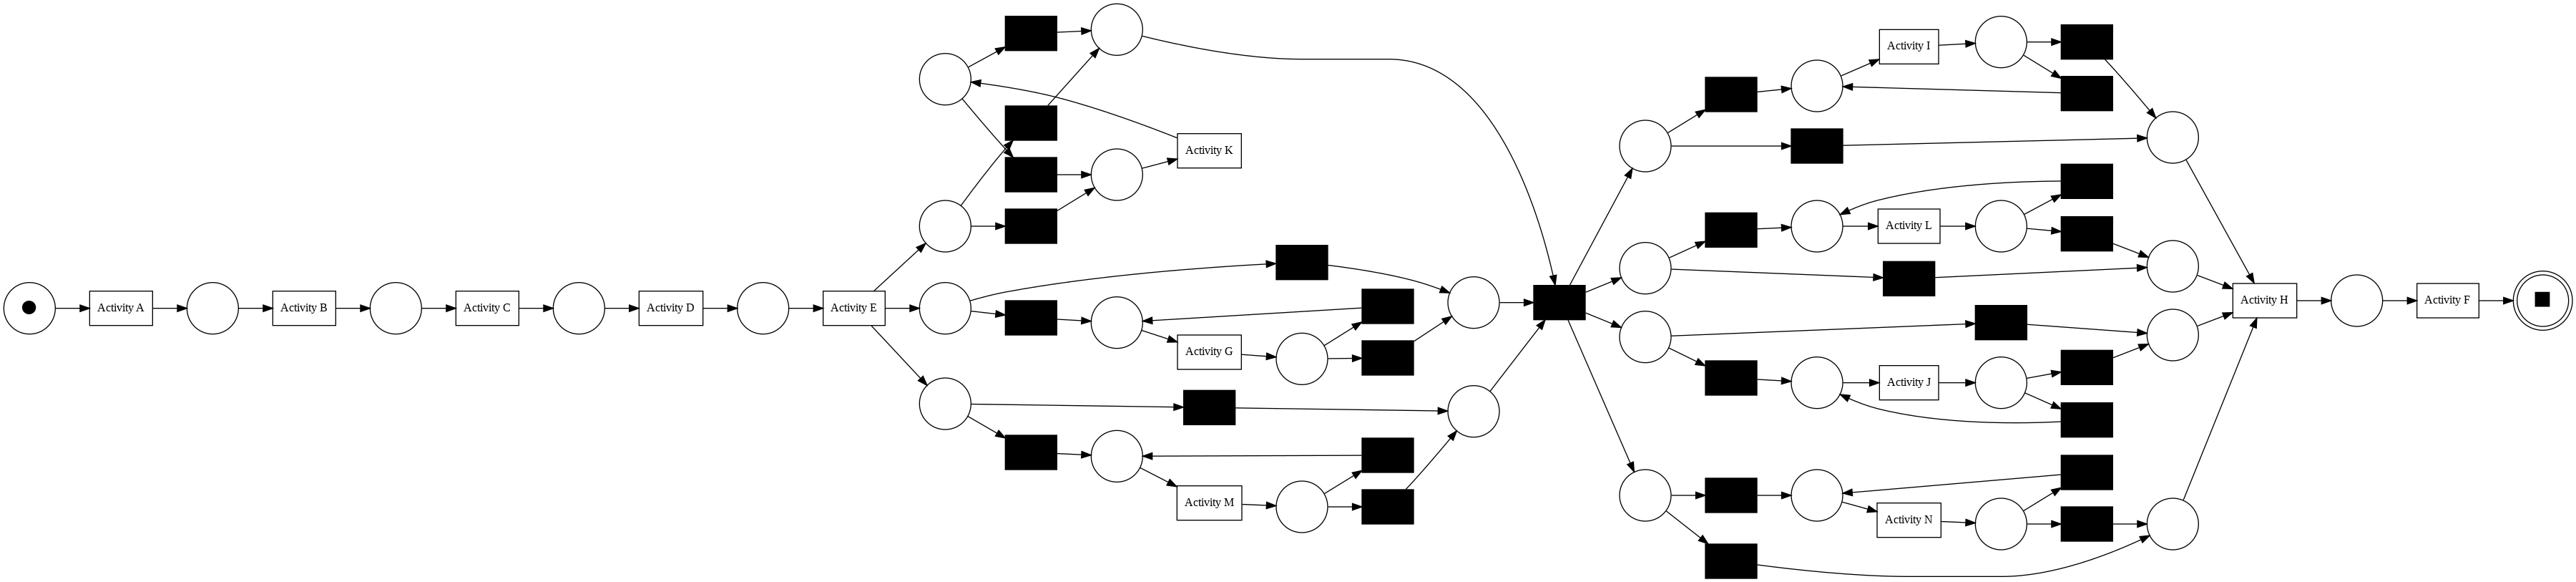

In [52]:
#visualizing the petri net
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz1 = pn_visualizer.apply(petri_net_im, initial_marking, final_marking)
pn_visualizer.view(gviz1)

### 2. Heuristics Miner

In [53]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
heu_net = heuristics_miner.apply_heu(event_log,
                                     parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.6})

AttributeError: module 'pm4py.util' has no attribute 'constants'

In [ ]:
#visualizing the heuristics net
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
gviz_h = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz_h)

### 3. Alpha Miner

In [55]:
#applying the alpha miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
petri_net_am, initial_markingg, final_markingg = alpha_miner.apply(event_log)

AttributeError: module 'pm4py.util' has no attribute 'xes_constants'

In [ ]:
#visualizing the petri net
gviz2 = pn_visualizer.apply(petri_net_am, initial_markingg, final_markingg)
pn_visualizer.view(gviz2)

## Analyzing original event log on discovered petri net model

In [56]:
file_name_2 = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.nan_pct))

with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load( f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)


In [73]:
data = pd.read_csv(args.data_dir + args.data_file, usecols=['Case ID', 'Activity', 'Complete Timestamp'])
data.head()

,Case ID,Activity,Complete Timestamp
0,Case 1,Activity A,1970/01/01 09:00:00.000
1,Case 1,Activity B,1970/01/01 10:00:00.000
2,Case 1,Activity C,1970/01/01 11:00:00.000
3,Case 1,Activity D,1970/01/01 12:00:00.000
4,Case 1,Activity E,1970/01/01 13:00:00.000


In [74]:
cols = ['case:concept:name', 'concept:name', 'time:timestamp']
data.columns = cols
data.head()

,case:concept:name,concept:name,time:timestamp
0,Case 1,Activity A,1970/01/01 09:00:00.000
1,Case 1,Activity B,1970/01/01 10:00:00.000
2,Case 1,Activity C,1970/01/01 11:00:00.000
3,Case 1,Activity D,1970/01/01 12:00:00.000
4,Case 1,Activity E,1970/01/01 13:00:00.000


In [75]:
# Convert Timestamp to time
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'], errors='coerce')
# Format Case column
data['case:concept:name'] = data['case:concept:name'].apply(lambda x: x.split(' ')[1]).astype('str')
data['case:concept:name'] = data['case:concept:name'].apply(pd.to_numeric).astype('str')
data['concept:name'] = data['concept:name'].astype('str')

In [76]:
event_log_orig = pm4py.convert_to_event_log(data)

### Token Based Replay of original event log on petri net of reconstructed log

In [77]:
replayed_traces_im_orig = pm4py.conformance_diagnostics_token_based_replay(event_log_orig, petri_net_im, initial_marking, final_marking)

replaying log with TBR, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

In [78]:
replayed_traces_im_orig[100]

{'trace_is_fit': True,
 'trace_fitness': 1.0,
 'activated_transitions': [(e9f9564d-1e8a-4de3-ace8-b3352179c164, 'Activity A'),
  (446d82b4-9e07-441d-9c4f-78957e882cdf, 'Activity B'),
  (21772ba8-a3fe-4025-aa06-7e6003be0333, 'Activity C'),
  (67b8db26-2729-4a7f-b967-c33b2e29e512, 'Activity D'),
  (bf0bd22b-5c46-40d3-9a96-bda9042408a7, 'Activity E'),
  (init_loop_4, None),
  (f5886677-da4d-4423-8fc7-4ddd9258282f, 'Activity K'),
  (init_loop_9, None),
  (93ef750b-14d2-4e48-9778-aa1d1246a529, 'Activity M'),
  (init_loop_14, None),
  (15c5c453-2b01-4fe1-9a43-d56714e6fddb, 'Activity G'),
  (skip_7, None),
  (skip_12, None),
  (skip_17, None),
  (tauJoin_2, None),
  (init_loop_26, None),
  (f48f486a-a0f7-40b8-b719-712feb3307cc, 'Activity L'),
  (init_loop_36, None),
  (0993993d-aea1-4dfe-bb54-7313a1f4cc45, 'Activity N'),
  (init_loop_21, None),
  (5fdd2d99-6b05-443c-b451-5c5da9c43e77, 'Activity I'),
  (init_loop_31, None),
  (01af78c0-dc3c-42c5-ab7c-79d6dbd3e786, 'Activity J'),
  (skip_24, No

### Obtaining Petri Net from original log

In [79]:
#using inductive miner to discover petri net model
petri_net_im_orig, initial_marking_orig, final_marking_orig = pm4py.discover_petri_net_inductive(event_log_orig)

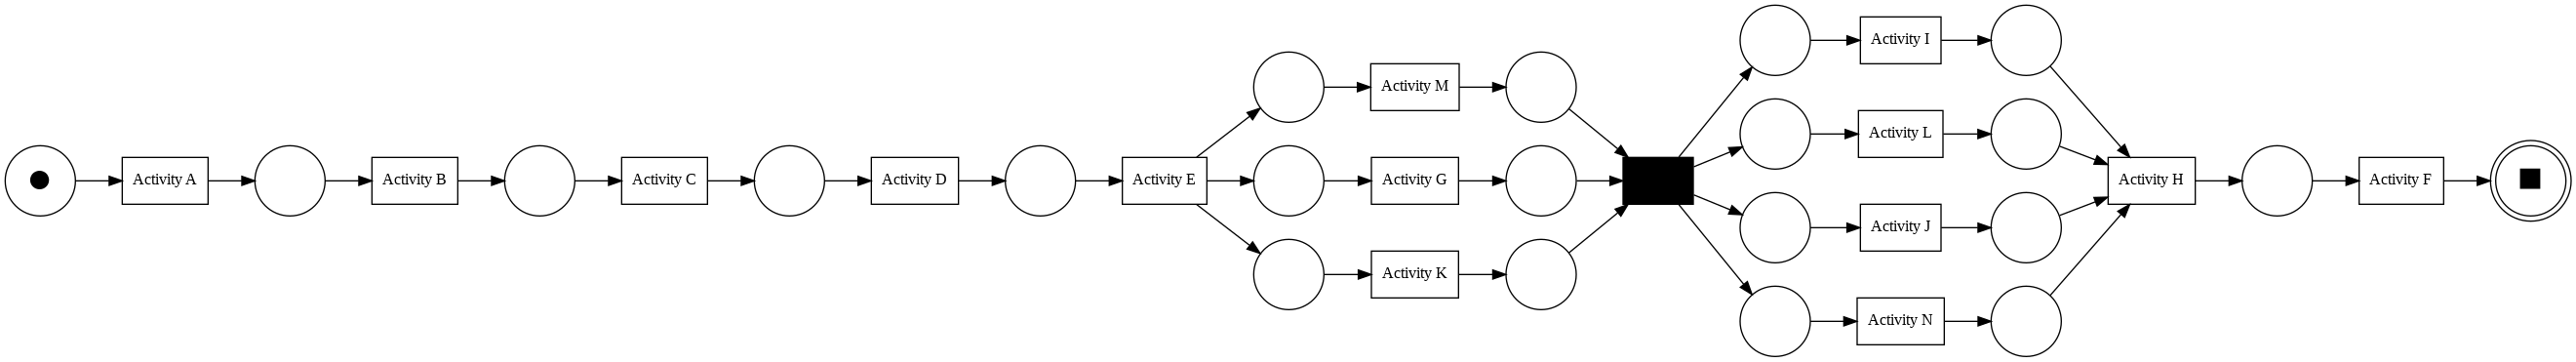

In [80]:
#visualizing the petri net
from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz3 = pn_visualizer.apply(petri_net_im_orig, initial_marking_orig, final_marking_orig)
pn_visualizer.view(gviz3)

We observe the given process model is close to the one discovered from the reconsturcted event log, which has a few more transitions owing to greater variability but overall structure is similar.

### Fitness of reconstructed event log on original petri net model
<hr>

#### 1. Using token based replay

In [ ]:
fitness_of_recons = pm4py.fitness_token_based_replay(event_log, petri_net_im_orig, initial_marking_orig, final_marking_orig)

In [ ]:
fitness_of_recons

#### 2. Using alignments

In [ ]:
fitness_of_recons_alignment = pm4py.fitness_alignments(event_log, petri_net_im_orig, initial_marking_orig, final_marking_orig)

In [ ]:
fitness_of_recons_alignment

### Fitness of original event log on petri net of reconstructed log
<hr>

#### 1. Using Token based replay

In [ ]:
fitness_of_orig = pm4py.fitness_token_based_replay(event_log_orig, petri_net_im, initial_marking, final_marking)

In [ ]:
fitness_of_orig

#### 2. Using alignments

In [ ]:
fitness_of_orig_alignment = pm4py.fitness_alignments(event_log_orig, petri_net_im, initial_marking, final_marking)

In [ ]:
fitness_of_orig_alignment

## Conformance Checking on reconstructed log and model

### 1. Token Based Replay

The output of the token-based replay, stored in the variable replayed_traces, contains for each trace of the log:

- trace_is_fit: boolean value (True/False) that is true when the trace is according to the model.
- activated_transitions: list of transitions activated in the model by the token-based replay.
- reached_marking: marking reached at the end of the replay.
- missing_tokens: number of missing tokens.
- consumed_tokens: number of consumed tokens.
- remaining_tokens: number of remaining tokens.
- produced_tokens: number of produced tokens.

In [ ]:
replayed_traces_im = pm4py.conformance_diagnostics_token_based_replay(event_log, petri_net_im, initial_marking, final_marking)

In [ ]:
replayed_traces_im[0]

### 2. Diagnostics (TBR)

The execution of token-based replay in PM4Py permits to obtain detailed information about transitions that did not execute correctly, or activities that are in the log and not in the model. In particular, executions that do not match the model are expected to take longer throughput time.

Hence, we perform a Throughput analysis.

In [ ]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay

In [ ]:
parameters_tbr = {token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.DISABLE_VARIANTS: True, token_based_replay.Variants.TOKEN_REPLAY.value.Parameters.ENABLE_PLTR_FITNESS: True}

In [ ]:
replayed_traces_im2, place_fitness, trans_fitness, unwanted_activities = token_based_replay.apply(event_log, petri_net_im,
                                                                                                  initial_marking,
                                                                                                  final_marking,
                                                                                                  parameters=parameters_tbr)

In [ ]:
replayed_traces_im2[0]

### 3. Throughput analysis for transitions executed unfit

In [ ]:
from pm4py.algo.conformance.tokenreplay.diagnostics import duration_diagnostics

In [ ]:
trans_diagnostics = duration_diagnostics.diagnose_from_trans_fitness(event_log, trans_fitness)

In [ ]:
trans_diagnostics

In [ ]:
for trans in trans_diagnostics:
    print(trans, trans_diagnostics[trans])

This means all transitions were executed.

### 4. Throughput analysis for unwanted activities

In [ ]:
act_diagnostics = duration_diagnostics.diagnose_from_notexisting_activities(event_log, unwanted_activities)
for act in act_diagnostics:
    print(act, act_diagnostics[act])

In [ ]:
act_diagnostics

### 5. Evaluating distribution of events over time

Here, we obtain a graph representing the distribution of events over time. It helps to understand in which time intervals the greatest number of events is recorded. The distribution related to events over time may be obtained.

In [81]:
from pm4py.algo.filtering.log.attributes import attributes_filter

In [82]:
x, y = attributes_filter.get_kde_date_attribute(event_log, attribute="time:timestamp")

In [83]:
from pm4py.visualization.graphs import visualizer as graphs_visualizer

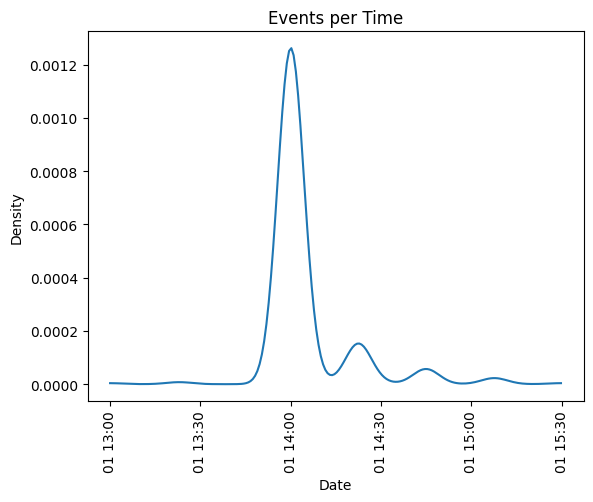

In [84]:
gviz_time = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
graphs_visualizer.view(gviz_time)

### 6. Distribution of events

Observing the distribution of events over time permits to infer useful information about the work shifts, the working days, and the period of the year that are more or less busy.

The possible values for the parameter distr_type are:

- hours: plots the distribution over the hours of a day.
- days_week: plots the distribution over the days of a week.
- days_month: plots the distribution over the days of a month.
- months: plots the distribution over the months of a year.
- years: plots the distribution over the different years of the log.

#### i) Reconstructed event log

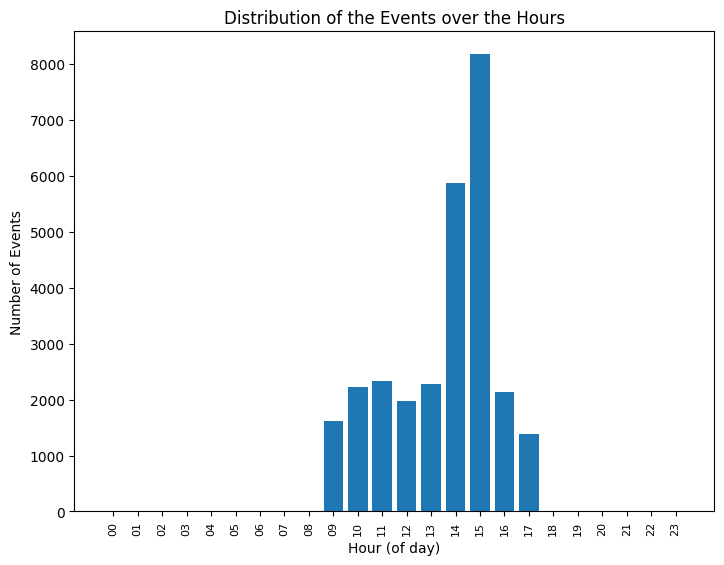

In [85]:
pm4py.view_events_distribution_graph(event_log, distr_type="hours", format="png")

#### ii) Original event log

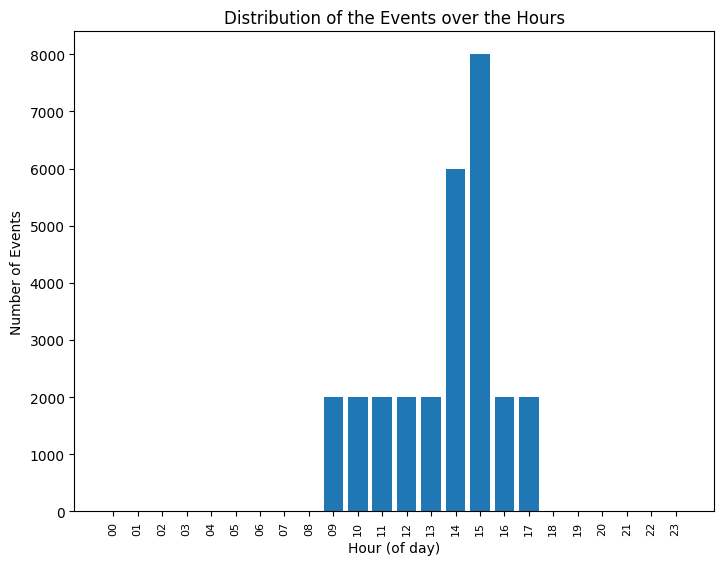

In [86]:
pm4py.view_events_distribution_graph(event_log_orig, distr_type="hours", format="png")

In [116]:
event_log

[{'attributes': {'concept:name': '1'}, 'events': [{'concept:name': 'Activity A', 'time:timestamp': Timestamp('1970-01-01 09:00:00'), '@@index': 0, '@@case_index': 0, 'case:concept:name': '0'}, '..', {'concept:name': 'Activity F', 'time:timestamp': Timestamp('1970-01-01 16:00:00.000865'), '@@index': 13, '@@case_index': 0, 'case:concept:name': '0'}]}, '....', {'attributes': {'concept:name': '999'}, 'events': [{'concept:name': 'Activity A', 'time:timestamp': Timestamp('1970-01-01 09:00:00'), '@@index': 27986, '@@case_index': 1999, 'case:concept:name': '1999'}, '..', {'concept:name': 'Activity F', 'time:timestamp': Timestamp('1970-01-01 17:00:00'), '@@index': 27999, '@@case_index': 1999, 'case:concept:name': '1999'}]}]

**Computing average error in predicting time of events**

In [ ]:
def compute_avg_error_in_time_prediction():


### 7. Comparing average activity durations

In [87]:
true_act = submission[[ 'TrueActivity', 'TrueTime']]
true_act.head()

,TrueActivity,TrueTime
0,Activity A,0.0
1,Activity B,3600.0
2,Activity C,7200.0
3,Activity D,10800.0
4,Activity E,14400.0


In [88]:
predicted_act = submission[[ 'PredictedActivity', 'PredictedTime']]
predicted_act.head()

,PredictedActivity,PredictedTime
0,Activity A,0.000000
1,Activity B,3600.000000
2,Activity C,7200.000000
3,Activity D,9422.900089
4,Activity E,14400.000000


In [89]:
true_act_avgtime = pd.DataFrame(true_act.groupby('TrueActivity')['TrueTime'].mean())
true_act_avgtime

,TrueTime
TrueActivity,
Activity A,0.0
Activity B,3600.0
Activity C,7200.0
Activity D,10800.0
Activity E,14400.0
Activity F,28800.0
Activity G,18000.0
Activity H,25200.0
Activity I,21600.0


In [90]:
pred_act_avgtime = pd.DataFrame(predicted_act.groupby('PredictedActivity')['PredictedTime'].mean())
pred_act_avgtime

,PredictedTime
PredictedActivity,
Activity A,1623.600000
Activity B,4260.360673
Activity C,7714.213555
Activity D,11040.701236
Activity E,14483.999356
Activity F,27329.406878
Activity G,18157.452021
Activity H,24877.588228
Activity I,21715.262998


In [91]:
merged_act_df = pd.concat([true_act_avgtime,pred_act_avgtime], axis=1)
merged_act_df

,TrueTime,PredictedTime
Activity A,0.0,1623.600000
Activity B,3600.0,4260.360673
Activity C,7200.0,7714.213555
Activity D,10800.0,11040.701236
Activity E,14400.0,14483.999356
Activity F,28800.0,27329.406878
Activity G,18000.0,18157.452021
Activity H,25200.0,24877.588228
Activity I,21600.0,21715.262998
Activity J,21600.0,21716.672668


In [92]:
merged_act_df['activity'] = merged_act_df.index

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

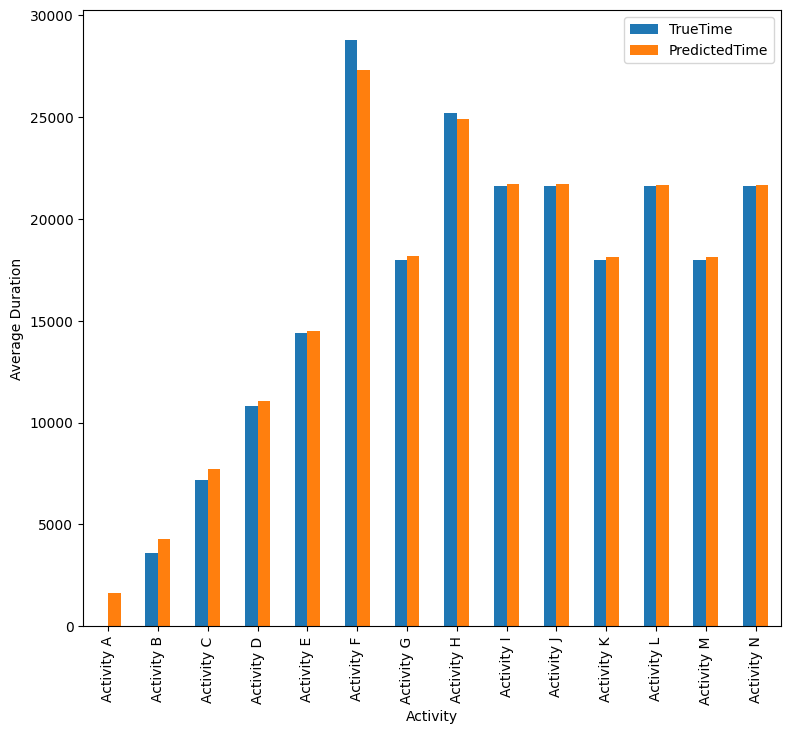

In [94]:
merged_act_df.plot(x="activity", y=["TrueTime", 'PredictedTime'], kind="bar",figsize=(9,8))
plt.xlabel("Activity")
plt.ylabel("Average Duration")
plt.show()

In [113]:
def compute_avg_perc_error(true_values, pred_values):
    res = 0
    for i in range(1, len(true_values)):
        error = abs(true_values[i] - pred_values[i])
        error = error/(true_values[i] + 1e-6) * 100
        res += error
    return res/len(true_values)

In [114]:
compute_avg_perc_error(list(merged_act_df['TrueTime']), list(merged_act_df['PredictedTime']))

2.7653488423438177